# Population estimation

Obtaining a dynamic population distribution is key to many decision-making processes such as urban planning, disaster management and most importantly helping the government to better allocate socio-technical supply. For the aspiration of these objectives, good population data is essential. In this tutorial, we will...

**[Part 1](#Part-1)**

1. Learn about the [Helmholtz AI CountMeIn](#1.-The-Challenge:-Helmholtz-AI-CountMeIn-(April-11-to-May-23,-2022)) challenge,
2. Meet [the data](#2.-The-data),
3. Explore a [random forest regressor](#3.-Random-forest-regressor)-based solution, and
4. Propose a simple [artificial neural network](#4.-Artificial-neural-network)-based solution. Then,

**[Part 2](#Part-2)**

5. We will use [data augmentation](#5.-Data-augmentation) to improve the performance, and
6. Explore [data fusion](#6.-Data-fusion) to benefit from all data sources. Finally,
7. The [open problems](#7.-Open-problems) and future directions will be listed.

# Part 1

## 1. The challenge: Helmholtz AI CountMeIn (April 11 to May 23, 2022)

[Helmholtz AI](https://www.helmholtz.ai/) is proud to announce an exciting data challenge: the Helmholtz AI CountMeIn Challenge. In this challenge, the participant teams will solve a challenging data science problem from the field of remote sensing: A spatially resolved estimate of the population based on satellite images. The task of the challenge is solving the problem up to a target accuracy with the smallest amount of resources possible. In two tracks, two of the most precious resources are addressed. In track GoGreen, the participant contribution wins that used as little energy. For the GoFast track, the task is to use as little time as possible.

This data challenge addresses a scientific audience, and therefore all participants are required to follow Good Scientific Practice. This means that for a valid submission, it is required to make code available, ensure reproducibility and document the steps to solution. The winning contributions to both tracks can present their solutions at the Helmholtz AI Conference.
For both tracks, you will be using the HAICORE installations located at Karlsruhe Institute of Technology (KIT) and Forschungszentrum Jülich (FZJ). The submission will happen on the newly formed [Helmholtz Data Challenges Platform](http://helmholtz-data-challenges.de/).

Even though the challenge ended, you can submit your results and compare the performance of your solution against the community on the [web](https://helmholtz-data-challenges.de/web/challenges/challenge-page/92/overview)

![Data sample](ancillary_rasters_example.png)

## 2. The data

Obtaining a dynamic population distribution is key to many decision-making processes such as urban planning, disaster management and most importantly helping the government to better allocate socio-technical supply. For the aspiration of these objectives, good population data is essential. In a view of this, we provide a comprehensive data set for population estimation in 98 European cities. The data set comprises digital elevation model, local climate zone, land use classifications, nighttime lights in combination with multi-spectral Sentinel-2 imagery, and data from the Open Street Map initiative.

The final data set consists of two parts, So2Sat POP Part1 and So2Sat POP Part2. All the data patches except OSM data are available as GeoTiff images with the pixel size of 10 m. Along with the raw OSM patches, we also provide the features extracted from the OSM data as the separate Comma Separated Value (CSV) files. So2Sat POP Part1 consists of the patches from local climate zones, land use classification, nighttime lights, Open Street Map and its features, and from all seasons (autumn, summer, spring, winter) of Sentinel-2 imagery (RGB), a total of 1,179,072 files. So2Sat POP Part2 consists of patches from digital elevation model only, a total of 131,008 files. So2Sat POP Part1 has the storage requirement of ~ 38 GB and So2Sat POP Part2 requires ~ 304 MB. Both parts of the data set consists of a predefined train and test split. Out of 98 cities, 78 cities (75% of the data) have been randomly selected as a training set and the rest of the 20 cities (25% of the data) constitute the test set.

More details can be found in the original [data set paper](https://arxiv.org/abs/2204.08524). 

```
@article{doda2022so2sat,
  title={So2Sat POP--A Curated Benchmark Data Set for Population Estimation from Space on a Continental Scale},
  author={Doda, Sugandha and Wang, Yuanyuan and Kahl, Matthias and Hoffmann, Eike Jens and Taubenböck, Hannes and Zhu, Xiao Xiang},
  journal={arXiv preprint arXiv:2204.08524},
  year={2022}
}

```

In this tutorial, we will use a subset of the original data set. Particularly, this subset contains the following data sources:

**Population data**: The European Statistical System (ESSnet) project, in co-operation with the European Forum for Geography and Statistics (EFGS), produced the high resolution (1km) population grids from the population census in Europe. We processed this freely available population grids for each city. 

**Sentinel-2 (SEN2)**: Processed only the RGB bands at 10 m resolution for all four seasonal sets (spring, summer, autumn and winter) of Sentinel-2 images to capture the seasonal variation in the data.

**Local climate zones (LCZ)**: Processed the urban local climate zone classifications, So2Sat LCZ v1.0, produced by fusing the freely available satellite data from Sentinel-1 and Sentinel-2 satellites using deep learning.

**Nighttime lights (VIIRS)**: Processed the freely available cloud free annual composites of global VIIRS nighttime lights.

**Land use classification (LU)**: Mapped OSM tags to a simplified land use classification scheme: commercial, industrial, residential, and other that results in a four band raster with corresponding land use proportions.

Train data is taken from Gdansk, while test data comes from Lublin.

In [ ]:
# uncomment to install the required packages
# import sys
# !{sys.executable} -m pip install -r requirements.txt
# or follow the instructions on https://github.com/acamero/data-science-eo-regression

In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(3108)

In [2]:
# this should match the name of the data sets
filename_train = 'data/train_countmein.h5'
filename_test = 'data/test_countmein.h5'

dataset_train = h5py.File(filename_train, 'r')
dataset_test = h5py.File(filename_test, 'r')

# show the content names
print(list(dataset_train.keys()))

['lcz', 'lu', 'population', 'sentinel2_autumn', 'sentinel2_spring', 'sentinel2_summer', 'sentinel2_winter', 'viirs']


In [3]:
pop_train = np.array(dataset_train['population'])

# show the shape
print("Population train data shape: ", pop_train.shape)

# print the ground truth for one sample
print("This is how the ground truth for one sample looks like:", pop_train[100,:])

# note that it is a pair (class, population count), thus we store just one part
pop_count_train = pop_train[:,1]

pop_test = np.array(dataset_test['population'])
pop_count_test = pop_test[:,1]

Population train data shape:  (267, 2)
This is how the ground truth for one sample looks like: [ 7 99]


Sentinel-2 shape:  (267, 100, 100, 3)


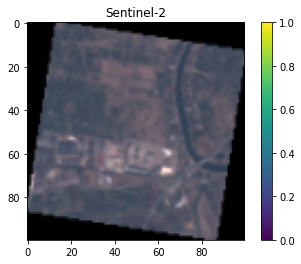

In [4]:
# load Sentinel-2 data (Spring snapshots)
sen2_spring_train = np.array(dataset_train['sentinel2_spring'])
sen2_spring_test = np.array(dataset_test['sentinel2_spring'])

print("Sentinel-2 shape: ", sen2_spring_train.shape)
# 267, 100x100 pixels, 3 channels samples

def norm_img(X):        
    return ((X - np.min(X)) / (np.max(X) - np.min(X)))
    

index = 119

plt.imshow(norm_img(sen2_spring_train[index,:]))
plt.colorbar()
plt.title('Sentinel-2')
plt.show()

VIIRS shape:  (267, 100, 100, 1)


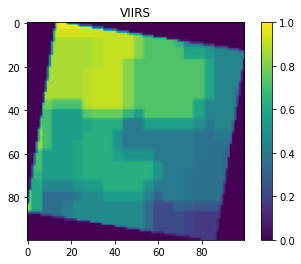

In [5]:
# load VIIRS
viirs_train = np.array(dataset_train['viirs'])

print("VIIRS shape: ", viirs_train.shape)
# 267, 100x100 pixels, 3 channels samples

def norm_img(X):        
    return ((X - np.min(X)) / (np.max(X) - np.min(X)))
    

plt.imshow(norm_img(viirs_train[index,:]))
plt.colorbar()
plt.title('VIIRS')
plt.show()

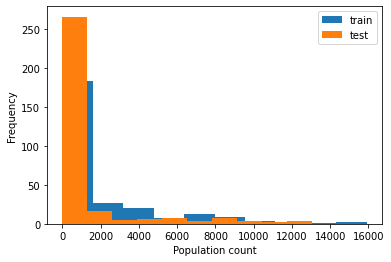

In [6]:
# let's check the population densitiy distribution of the samples
plt.hist(pop_count_train, label="train")
plt.hist(pop_count_test, label="test")
plt.xlabel("Population count")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()

### Do it yourself

Load and plot *land usage* (lu) and  *local climate zone* (lcz) data.

In [ ]:
# load Sentinel-2 data (Spring snapshots)
sen2_winter_train = np.array(dataset_train['sentinel2_winter'])

plt.imshow(norm_img(sen2_spring_train[index,:]))
plt.title('Sentinel-2 spring')
plt.show()
plt.title('Sentinel-2 winter')
plt.imshow(norm_img(sen2_winter_train[index,:]))

# LU -> commercial, industrial, residential, and other that results in a four 
# band raster with corresponding land use proportions.

## 3. Random forest regressor

A random forest regressor is a meta estimator that fits a number of classifying regression trees on various sub-samples of the dataset and uses *averaging* to improve the regression performance and control over-fitting. Note: a simple example of a decision tree can be found [here](./decision_trees.pdf)

![Random forest regressor](rf-regressor.png)

In [7]:
# Random forest regressor needs a vector as input
_shape = sen2_spring_train.shape
X_train = np.reshape(sen2_spring_train, (_shape[0], _shape[1] * _shape[2] * _shape[3]))
print("X train shape:", X_train.shape)

n_test = sen2_spring_test.shape[0]
X_test = np.reshape(sen2_spring_test, (n_test, _shape[1] * _shape[2] * _shape[3]))
print("X test shape:", X_test.shape)

X train shape: (267, 30000)
X test shape: (324, 30000)


In [8]:
# The details of the RandomForestRegressor can be found at https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
rf_base = RandomForestRegressor(random_state=3108)

rf_base.fit(X_train, pop_count_train)

RandomForestRegressor(random_state=3108)

In [9]:
pop_pred_rf = rf_base.predict(X_test)

In [10]:
mae_base = mean_absolute_error(pop_count_test, pop_pred_rf)
rmse_base = mean_squared_error(pop_count_test, pop_pred_rf, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_base = r2_score(pop_count_test, pop_pred_rf)

print("MAE:", mae_base) # Best possible is 0
print("RMSE:", rmse_base) # Best possible is 0
print("R2:", r2_base) # Best possible is 1

MAE: 2855.3273148148146
RMSE: 3273.3599399767745
R2: -0.6254334813250992


Total population in test set: 379191
Total population predicted: 935716
Average population per sample in test set: 1170.3425925925926
Average population per sample in predicted set: 2888.0149691358024


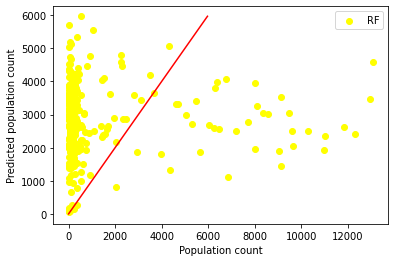

In [11]:
print("Total population in test set:", np.sum(pop_count_test))
print("Total population predicted:", int(np.sum(pop_pred_rf)))

print("Average population per sample in test set:", np.average(pop_count_test))
print("Average population per sample in predicted set:", np.average(pop_pred_rf))

lim = int(np.min( [np.max(pop_count_test), np.max(pop_pred_rf)]))

plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Predicted population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

### Do it yourself

Use a random forest to estimate the population using VIIRS nighlights.

### Pro tip

There are several machine learning algorithms/models you can use to address this task. Visit https://scikit-learn.org/stable/ to check some off-the-shelf alternatives. Below, you will find an example using the so called Support Vector Regression method. Note: Even though using such methods is quite simple (in terms of coding), please, be aware that getting to know how these methods work could make a big difference. In plain English, feel free to play around with all methods, but try to understand what you are doing.

MAE: 1162.7937732773505
RMSE: 2682.8551308536335
R2: -0.09188303803994868


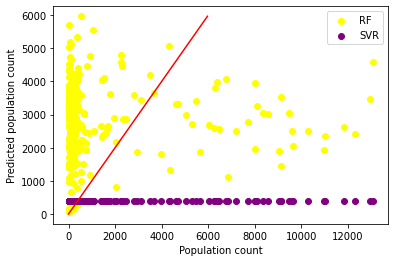

In [12]:
svm_regr = svm.SVR()
svm_regr.fit(X_train, pop_count_train)
pop_pred_svr = svm_regr.predict(X_test)
mae_svr = mean_absolute_error(pop_count_test, pop_pred_svr)
rmse_svr = mean_squared_error(pop_count_test, pop_pred_svr, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_svr = r2_score(pop_count_test, pop_pred_svr)

print("MAE:", mae_svr) # Best possible is 0
print("RMSE:", rmse_svr) # Best possible is 0
print("R2:", r2_svr) # Best possible is 1

lim = int(np.max( [lim, np.max(pop_pred_svr)]))

plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.scatter(pop_count_test, pop_pred_svr, label="SVR", color="purple")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Predicted population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

## 4. Artificial neural network

The human brain is a *machine* capable of performing very complex tasks, such as pattern recognition, motor control of a limb or perception of sensory stimuli, much faster than any machine invented by man. For this reason, great efforts have been (and continue to be) made to understand how they work. 

This machine is made up of about 100 trillion neurons (cells of the nervous system specialized in the reception and conduction of stimuli), which communicate with each other, forming complex circuits, which are capable of carrying out brain function. This biological model was the inspiration for McCulloch and Pitts to propose a [new computer model](https://www.cs.cmu.edu/~./epxing/Class/10715/reading/McCulloch.and.Pitts.pdf) in 1943: the *artificial neural network* (ANN).

An ANN is a network of computer units (neurons) connected to each other, where each unit performs a calculation from an input and communicates its result (output) to the connected units. Typically, the connections are weighted, which indicates how strong the connection between two units is. Also, the calculation units are usually grouped into modules or layers. ANNs have properties and capabilities that are very useful for solving complex problems, highlighting its nonlinearity, adaptability, fault tolerance, among others. Thanks to these properties it has been possible to overcome the results obtained in multiple problems.

![Artificial neural network](ann.png)

> Deep-learning methods are representation-learning methods with multiple levels of representation, obtained by composing simple but non-linear modules that each transform the representation at one level (starting with the raw input) into a representation at a higher, slightly more abstract level. With the composition of enough such transformations, very complex functions can be learned. *Yann LeCun, Yoshua Bengio and Geoffrey Hinton, 2015*

In [13]:
simple_nn = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1], _shape[2], _shape[3])),
  tf.keras.layers.Dense(128, activation='relu'),  
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1),
])

simple_nn.compile(optimizer='adam',
              loss='mean_absolute_error')

In [14]:
simple_nn.fit(sen2_spring_train, pop_count_train, epochs=5)

Epoch 1/5
9/9 [==============================] - 0s 13ms/step - loss: 13990.6553
Epoch 2/5
9/9 [==============================] - 0s 15ms/step - loss: 5319.5552
Epoch 3/5
9/9 [==============================] - 0s 14ms/step - loss: 4156.1782
Epoch 4/5
9/9 [==============================] - 0s 13ms/step - loss: 3361.6509
Epoch 5/5
9/9 [==============================] - 0s 13ms/step - loss: 2408.6206


In [15]:
pop_pred_nn = simple_nn.predict(sen2_spring_test)

In [16]:
mae_nn = mean_absolute_error(pop_count_test, pop_pred_nn)
rmse_nn = mean_squared_error(pop_count_test, pop_pred_nn, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn = r2_score(pop_count_test, pop_pred_nn)

print("MAE:", mae_nn) # Best possible is 0
print("RMSE:", rmse_nn) # Best possible is 0
print("R2:", r2_nn) # Best possible is 1

MAE: 2206.135705170808
RMSE: 2743.5557899848254
R2: -0.1418505540270938


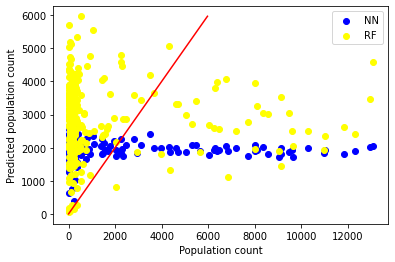

In [17]:
lim = int(np.max( [lim, np.max(pop_pred_nn)]))

plt.scatter(pop_count_test, pop_pred_nn, label="NN", color="blue")
plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Predicted population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

### Do it yourself

Modify the *simple_nn* model to estimate the population using VIIRS nightlights.

Neural networks are very sensitive to their hyperparameters. Therefore, let us dig a bit into the details...

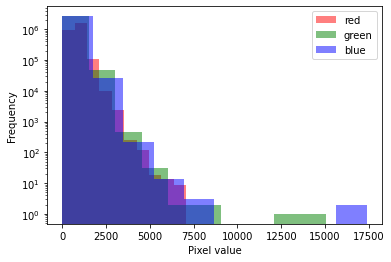

In [18]:
plt.hist(sen2_spring_train[:,:,:,0].flatten(), label="red", color="red", alpha=0.5)
plt.hist(sen2_spring_train[:,:,:,1].flatten(), label="green", color="green", alpha=0.5)
plt.hist(sen2_spring_train[:,:,:,2].flatten(), label="blue", color="blue", alpha=0.5)
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.yscale("log")
plt.show()

It looks like a good idea to *standarize* the data.

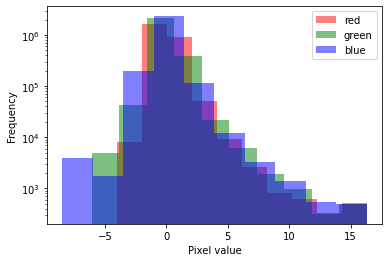

In [19]:
s2_scaler = StandardScaler()
s2_scaler.fit(sen2_spring_train.reshape((_shape[0], _shape[1] * _shape[2] * _shape[3])))
sen2_spring_train_stdized = s2_scaler.transform(
    sen2_spring_train.reshape((_shape[0], _shape[1] * _shape[2] * _shape[3])))
sen2_spring_train_stdized = sen2_spring_train_stdized.reshape((_shape[0], _shape[1], _shape[2], _shape[3]))

plt.hist(sen2_spring_train_stdized[:,:,:,0].flatten(), label="red", color="red", alpha=0.5)
plt.hist(sen2_spring_train_stdized[:,:,:,1].flatten(), label="green", color="green", alpha=0.5)
plt.hist(sen2_spring_train_stdized[:,:,:,2].flatten(), label="blue", color="blue", alpha=0.5)
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.yscale("log")
plt.show()

Now, let's normalize the *output*...

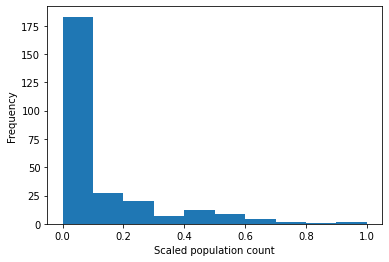

In [20]:
pop_scaler = MinMaxScaler() 
pop_scaler.fit(pop_count_train.reshape(-1,1))
scaled_pop_count_train = pop_scaler.transform(pop_count_train.reshape(-1,1))

plt.hist(scaled_pop_count_train, label="train")
plt.xlabel("Scaled population count")
plt.ylabel("Frequency")
plt.show()

Let us have a look into the activation functions...

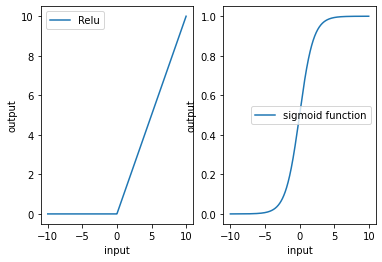

In [21]:
x = np.linspace(-10, 10, 1000)
y_sigmoid = 1 / (1 + np.exp(-x) )
y_relu = np.maximum(0, x)

plt.subplot(1,2,1)
plt.plot(x, y_relu)
plt.legend(['Relu'])
plt.xlabel('input')
plt.ylabel('output')

plt.subplot(1,2,2)
plt.plot(x, y_sigmoid)
plt.legend(['sigmoid function'])
plt.xlabel('input')
plt.ylabel('output')
plt.show()

Epoch 1/5
9/9 [==============================] - 0s 12ms/step - loss: 0.3954
Epoch 2/5
9/9 [==============================] - 0s 13ms/step - loss: 0.1868
Epoch 3/5
9/9 [==============================] - 0s 13ms/step - loss: 0.1302
Epoch 4/5
9/9 [==============================] - 0s 13ms/step - loss: 0.1141
Epoch 5/5
9/9 [==============================] - 0s 12ms/step - loss: 0.1093
MAE: 1484.926122971523
RMSE: 2544.5928807528744
R2: 0.017758474396755486


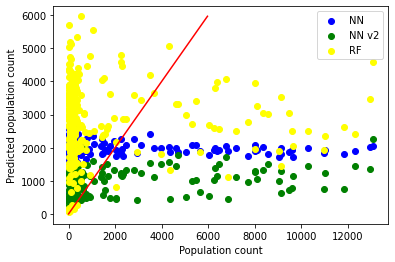

In [22]:
simple_nn_v2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1], _shape[2], _shape[3])),
  tf.keras.layers.Dense(128, activation='sigmoid'),  
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

simple_nn_v2.compile(optimizer='adam',
              loss='mean_absolute_error')

simple_nn_v2.fit(sen2_spring_train_stdized, scaled_pop_count_train, epochs=5)

sen2_spring_test_stdized = s2_scaler.transform(
    sen2_spring_test.reshape((n_test, _shape[1] * _shape[2] * _shape[3])))
sen2_spring_test_stdized = sen2_spring_test_stdized.reshape((n_test, _shape[1], _shape[2], _shape[3]))

pop_pred_nn_scaled_v2 = simple_nn_v2.predict(sen2_spring_test_stdized)
pop_pred_nn_v2 = pop_scaler.inverse_transform(pop_pred_nn_scaled_v2)

mae_nn_v2 = mean_absolute_error(pop_count_test, pop_pred_nn_v2)
rmse_nn_v2 = mean_squared_error(pop_count_test, pop_pred_nn_v2, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn_v2 = r2_score(pop_count_test, pop_pred_nn_v2)

print("MAE:", mae_nn_v2) # Best possible is 0
print("RMSE:", rmse_nn_v2) # Best possible is 0
print("R2:", r2_nn_v2) # Best possible is 1

lim = int(np.max( [lim, np.max(pop_pred_nn_v2)]))

plt.scatter(pop_count_test, pop_pred_nn, label="NN", color="blue")
plt.scatter(pop_count_test, pop_pred_nn_v2, label="NN v2", color="green")
plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Predicted population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

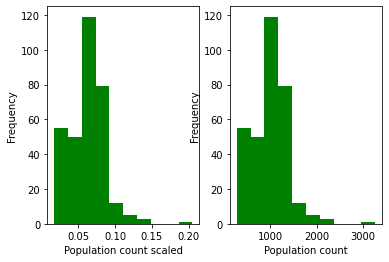

In [23]:
plt.subplot(1,2,1)
plt.hist(pop_pred_nn_scaled_v2, color='green')
plt.xlabel("Population count scaled")
plt.ylabel("Frequency")


plt.subplot(1,2,2)
plt.hist(pop_pred_nn_v2, color='green')
plt.xlabel("Population count")
plt.ylabel("Frequency")
plt.show()

### Do it yourself

Explore what happens if you change the number of neurons per layer. How about adding an additional layer?

In [ ]:
simple_nn_v2.summary()

# Part 2

## 5. Data augmentation

ANN (and specially *deep learning* models) are data hungry. Moreover, if not enough training data is given, ANN are prone to overfit the samples. The latter is also related to the *generalization* capability of the model. To overcome these issues, *data augmentation* can be use. Data augmentation consists of increasing the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

In [ ]:
def augment_sample(img, seed=None):
    img_flip_lr = tf.image.flip_left_right(img).numpy()
    img_flip_ud = tf.image.flip_up_down(img).numpy()
    img_bright = tf.image.random_brightness(img, max_delta=0.01, seed=seed).numpy()
    img_contrast = tf.image.random_contrast(img, lower=0.2, upper=0.5, seed=seed).numpy()
    img_saturation = tf.image.random_saturation(img, lower=5, upper=10, seed=seed).numpy()
    img_jpeg = tf.image.random_jpeg_quality(img, min_jpeg_quality=55, max_jpeg_quality=95, seed=seed).numpy()
    img_hue = tf.image.random_hue(img, max_delta=0.2, seed=seed).numpy()
    return (img,
           img_flip_lr,
           img_flip_ud,
           img_bright,
           img_contrast,
           img_saturation,
           img_jpeg,
           img_hue)

In [ ]:
aug = augment_sample(sen2_spring_train[0], seed=3108)
fig=plt.figure(figsize=(12, 12))

for i in range(len(aug)):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(norm_img(aug[i]))

plt.show()

In [ ]:
tmp_train = ()
tmp_count = np.array(())

for i in range(len(sen2_spring_train_stdized)):
    aug = augment_sample(sen2_spring_train_stdized[i], seed=3108)
    tmp_train = tmp_train + aug
    tmp_count = np.hstack((tmp_count, np.repeat(scaled_pop_count_train[i], len(aug))))

sen2_spring_aug_train_stdized = np.stack(tmp_train)
print("Augmented data set shape", sen2_spring_aug_train_stdized.shape)

scaled_pop_count_aug_train = tmp_count.reshape(-1, 1)
print("Augmented labels shape", scaled_pop_count_aug_train.shape)

In [ ]:
sen2_spring_train_stdized.shape

In [ ]:
simple_nn_v3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1], _shape[2], _shape[3])),
  tf.keras.layers.Dense(128, activation='sigmoid'),  
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

simple_nn_v3.compile(optimizer='adam',
              loss='mean_absolute_error')

simple_nn_v3.fit(sen2_spring_aug_train_stdized, scaled_pop_count_aug_train, epochs=5)

pop_pred_nn_scaled_v3 = simple_nn_v3.predict(sen2_spring_test_stdized)
pop_pred_nn_v3 = pop_scaler.inverse_transform(pop_pred_nn_scaled_v3)

mae_nn_v3 = mean_absolute_error(pop_count_test, pop_pred_nn_v3)
rmse_nn_v3 = mean_squared_error(pop_count_test, pop_pred_nn_v3, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn_v3 = r2_score(pop_count_test, pop_pred_nn_v3)

print("MAE:", mae_nn_v3) # Best possible is 0
print("RMSE:", rmse_nn_v3) # Best possible is 0
print("R2:", r2_nn_v3) # Best possible is 1

lim = int(np.max( [lim, np.max(pop_pred_nn_v3)]))

plt.scatter(pop_count_test, pop_pred_nn, label="NN", color="blue")
plt.scatter(pop_count_test, pop_pred_nn_v2, label="NN v2", color="green")
plt.scatter(pop_count_test, pop_pred_nn_v3, label="NN v3", color="gray")
plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Predicted population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

### Do it yourself

Add another data augmentation, e.g., combine several augmentation operations (flip and contrast).

# 6. Data fusion

There are several ways of *using* all data sources. Generally speaking, the *data fusion* process can occur at a (1) low level (e.g., concatenate/stack the data patches), (2) feature level (e.g., inside the model), or (3) decision level (e.g., combine the predictions of models that process different data sources).

![Data fusion](data_fusion.png)

In [ ]:
sen2_autumn_train = np.array(dataset_train['sentinel2_autumn'])
sen2_autumn_test = np.array(dataset_test['sentinel2_autumn'])

sen2_fused_train = np.concatenate((sen2_spring_train, sen2_autumn_train), axis=-1)
sen2_fused_test = np.concatenate((sen2_spring_test, sen2_autumn_test), axis=-1)

print("Train data set shape", sen2_fused_train.shape)
print("Test data set shape", sen2_fused_test.shape)

plt.hist(sen2_fused_train[:,:,:,0].flatten(), label="red", color="red", alpha=0.5)
plt.hist(sen2_fused_train[:,:,:,1].flatten(), label="green", color="green", alpha=0.5)
plt.hist(sen2_fused_train[:,:,:,2].flatten(), label="blue", color="blue", alpha=0.5)
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.yscale("log")
plt.show()

In [ ]:
_shape_fused = sen2_fused_train.shape

s2_fused_scaler = StandardScaler()
s2_fused_scaler.fit(sen2_fused_train.reshape((_shape_fused[0], _shape_fused[1] * _shape_fused[2] * _shape_fused[3])))
sen2_fused_train_stdized = s2_fused_scaler.transform(
    sen2_fused_train.reshape((_shape_fused[0], _shape_fused[1] * _shape_fused[2] * _shape_fused[3])))
sen2_fused_train_stdized = sen2_fused_train_stdized.reshape((_shape_fused[0], _shape_fused[1], _shape_fused[2], _shape_fused[3]))

print("Standardized train data set shape", sen2_fused_train_stdized.shape)

plt.hist(sen2_fused_train_stdized[:,:,:,0].flatten(), label="red", color="red", alpha=0.5)
plt.hist(sen2_fused_train_stdized[:,:,:,1].flatten(), label="green", color="green", alpha=0.5)
plt.hist(sen2_fused_train_stdized[:,:,:,2].flatten(), label="blue", color="blue", alpha=0.5)
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.yscale("log")
plt.show()

In [ ]:
simple_nn_fused = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape_fused[1], _shape_fused[2], _shape_fused[3])),
  tf.keras.layers.Dense(128, activation='sigmoid'),  
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

simple_nn_fused.compile(optimizer='adam',
              loss='mean_absolute_error')

simple_nn_fused.fit(sen2_fused_train_stdized, scaled_pop_count_train, epochs=5)

sen2_fused_test_stdized = s2_fused_scaler.transform(
    sen2_fused_test.reshape((n_test, _shape_fused[1] * _shape_fused[2] * _shape_fused[3])))
sen2_fused_test_stdized = sen2_fused_test_stdized.reshape((n_test, _shape_fused[1], _shape_fused[2], _shape_fused[3]))

pop_pred_nn_scaled_fused = simple_nn_fused.predict(sen2_fused_test_stdized)
pop_pred_nn_fused = pop_scaler.inverse_transform(pop_pred_nn_scaled_fused)

mae_nn_fused = mean_absolute_error(pop_count_test, pop_pred_nn_fused)
rmse_nn_fused = mean_squared_error(pop_count_test, pop_pred_nn_fused, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn_fused = r2_score(pop_count_test, pop_pred_nn_fused)

print("MAE:", mae_nn_fused) # Best possible is 0
print("RMSE:", rmse_nn_fused) # Best possible is 0
print("R2:", r2_nn_fused) # Best possible is 1

lim = int(np.max( [lim, np.max(pop_pred_nn_fused)]))

plt.scatter(pop_count_test, pop_pred_nn, label="NN", color="blue")
plt.scatter(pop_count_test, pop_pred_nn_v2, label="NN v2", color="green")
plt.scatter(pop_count_test, pop_pred_nn_v3, label="NN v3", color="gray")
plt.scatter(pop_count_test, pop_pred_nn_fused, label="NN fused", color="orange")
plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Predicted population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

### Do it yourself

Propose a model that performs the data fusion at a decision level.

# 7. Open problems

So far, we have explored just the tip of the iceberg. Particularly, this is an imbalanced problem, and the geographical variability imposes a generalization challenge. Moreover, the multi-modality of the data offers opportunities, but it is challenging to get the most out of it. Generally speaking, remote sensing data bring new challenges for deep learning, since satellite image analysis raises some unique questions that translate into challenging new scientific questions. Particularly, remote sensing data is:
- Multi-modal, thus it requires transfering learning from different modalities and (different) sensor fusion.
- Geo-located, i.e., each pixel corresponds to a spatial coordinate. Thus, it can be fused with other data sources, and enables new applications, e.g., geo-located services.
- Quality controlled measurements, with confidence estimates. Therefore, things like estimating the uncertainty of the prediction made by a DL model become extremely important.
- Time-dependent, thus requires tailoring models.
- Big, i.e., we are talking about PB of data, and in consequence efficient models are needed. Also, most data is unlabeled, thus learning with few labeled data is critical.
- Geo-physical or bio-chemical quantities, so to interpret the data expert knowledge is needed.

Besides these challenges, automating the whole process is needed (AutoML) but considering all the particularities; and we must consider the ethical implications of working with Earth observation data!

![Open problems](open_problems.png)

### Challenge

Propose a model that improves the baseline performance of the [data set paper](https://arxiv.org/abs/2204.08524).